In [1]:
# Three helpers functions are used to preprocess the dataset, plot diagrams and to perform wavelet packet decompositions
# please check them under the helpers folder
from helpers.DatasetProcess import dataset_to_df,get_classes
from helpers.PlotExtension import norm_to_plot, img_plot
from helpers.WaveletPacket import wpt_dec, plot_wpt_nodes, plot_wpt_fun, wavelet_families, get_maxlevel

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn

# Pytorch is used to build the model
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import CrossEntropyLoss

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau , CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, recall_score, f1_score , roc_auc_score

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

(7444889600, 8589410304)

### First: Load the Dataset and Get Some Statistics

In [4]:
dataset_name = "CIFAKE"
path = '../../data/CIFAKE'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
original_split = ["train", "train", "test", "test"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]
map_cat = {"REAL": 0, "FAKE": 1}

re_split = False

# re-split determines whether to split the dataset into train , valid and test based on desired ratios
# if re-split is set to false , then dataset will be taken as is based on it's original splits and the below ratios
# will be ignored. Otherwise if re_split is set to True , then you can decide the split ratios as follows:
train_ratio = 0.8
valid_ratio = 0.14
test_ratio = 1-(train_ratio+valid_ratio)

if re_split:
    print(f'({train_ratio},{valid_ratio},{1-train_ratio-valid_ratio})')
else:
    print('Using the original dataset splits without change')

Using the original dataset splits without change


In [5]:
classes = get_classes(map_cat)
classes

['REAL', 'FAKE']

In [6]:
try:
    df_all = pd.read_csv(f'{path}/df_all.csv')
    df_train = pd.read_csv(f'{path}/df_train.csv')
    df_val = pd.read_csv(f'{path}/df_val.csv')
    df_test = pd.read_csv(f'{path}/df_test.csv')
    classes_stats = pd.read_csv(f'{path}/classes_stats.csv')
except FileNotFoundError:
    df_all, df_train, df_val, df_test, classes_stats = dataset_to_df( path, relative_paths, paths_classes,map_cat, original_split, re_split, train_ratio, valid_ratio, test_ratio)
    df_all.to_csv(f'{path}/df_all.csv', index=False)
    df_train.to_csv(f'{path}/df_train.csv', index=False)
    df_val.to_csv(f'{path}/df_val.csv', index=False)
    df_test.to_csv(f'{path}/df_test.csv', index=False)
    classes_stats.to_csv(f'{path}/classes_stats.csv')

classes_stats

,Unnamed: 0,REAL,FAKE,Total
0,Training,50000,50000,100000
1,Validation,10000,10000,20000
2,Testing,10000,10000,20000
3,Row_Total,70000,70000,140000


In [7]:
df_test.iloc[[0, -1]]

,Image_path,Height,Width,Channels,Class,Class_Codes,Class_Onehot
0,../../data/CIFAKE//test/REAL/0979(8).jpg,32,32,RGB,REAL,0,[0 1]
19999,../../data/CIFAKE//test/FAKE/712(5).jpg,32,32,RGB,FAKE,1,[1 0]


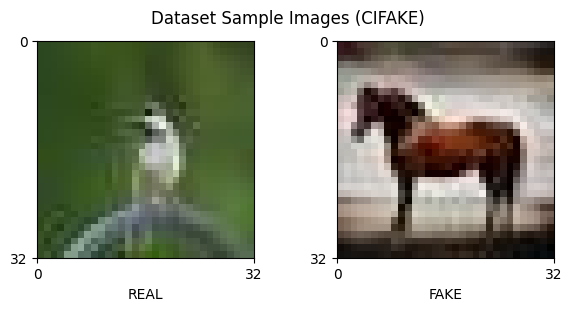

In [8]:
r_img_idx, f_img_idx = 82, -3
step = 32


fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(6, 3))
fig.suptitle(f'Dataset Sample Images ({dataset_name})')

r_img = read_image(df_all.iloc[r_img_idx, 0])
f_img = read_image(df_all.iloc[f_img_idx, 0])

n = r_img.shape[1]
extent = [0, n, n, 0]

axs[0].imshow(r_img.permute(1, 2, 0), extent=extent)
axs[0].set(xlabel=df_all.iloc[r_img_idx, 4])
axs[0].set(xticks=np.arange(0, r_img.shape[2]+1, step=step),
           yticks=np.arange(0, r_img.shape[1]+1, step=step))

axs[1].imshow(f_img.permute(1, 2, 0), extent=extent)
axs[1].set(xlabel=df_all.iloc[f_img_idx, 4])
axs[1].set(xticks=np.arange(0, f_img.shape[2]+1, step=step),
           yticks=np.arange(0, f_img.shape[1]+1, step=step))

plt.show()

### Second: Define the Hyper Parameters of the Model

In [9]:
n_extra_epochs = 200

use_scheduler = True
continue_lr = False

start_from_model = True
max_epochs = None #300
# If start_from_model is True, then load a pretrained model and continue training after the model last epoch
# Training will continue until reach to max_epochs (integer number)
# if max_epochs = None ==> there will be no upper limit for last epoch 

In [10]:
# Define the Path of the Model
model_type = "vit"
weights_folder_path = "../weights"
model_folder = "CIFAKE"

checkpoint_folder = "WPT-ViT_db2_L3_P1_H18_E1_S1_B1000_D32_CIFAKE"


# now put a label for the saved model
model_code = checkpoint_folder.split("_")[0]+"_"+checkpoint_folder.split("_")[1]+"_"+''.join(checkpoint_folder.split("_")[2:9])+"_"+checkpoint_folder.split("_")[9]

print(model_code)

# The above Folder name reflects the key model hyper parameters, as follows:

# Model Type: (e.g. VITWPT)
# wavelet_fun : Name of the wavelet function (e.g. db2)
# wavelet_level(L) : The maximum level to which image will be decomposed (e.g. L3)
# Patches per decomposition(P): Number of patches (slices) per each WPT decomposition (e.g. P1)
# Heads(H): Number of heads of the transformer (e.g. H36)
# encoder_levels : Number of stacked encoders (e.g. E1)
# Sliced? (S: Whether we are using a subset of the WPT decompositions (True:1 , False:0) (e.g. S0)
# Batch_size(B): Batch Size that fed to the model.
# Dimension(D): The Dimension of the Dataset after (resize) (e.g. D32)
# Dataset: Name of the Dataset (e.g. CIFAKE)

WPT-ViT_db2_L3P1H18E1S1B1000D32_CIFAKE


In [11]:
# file name of the saved model
if start_from_model:
    model_file_name = f"WPT-ViT_db2_L3P1H18E1S1B1000D32_CIFAKE_ph1_ep180_acc91.75"

In [12]:
model_state_path = f"{weights_folder_path}/{model_folder}/{checkpoint_folder}/"

if start_from_model:
    checkpoint = torch.load(model_state_path+model_file_name)

In [13]:
start_epoch = checkpoint['epoch_lst'][-1] if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if max_epochs == None else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 200 epochs after epoch 180 


In [14]:
if start_from_model:
    training_phase_lst = checkpoint['training_phase_lst']
    training_phase = training_phase_lst[-1]+1
else: 
    training_phase = 1

print(training_phase)

2


In [15]:
wavelet_families()

0) haar: haar
1) db: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
2) sym: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
3) coif: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
4) bior: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
5) rbio: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
6) dmey: dmey
 



In [16]:
# Wavelet Packet Transform Hyper Parameters
wpt_fun = 'db2'
wpt_level = 3
wpt_mode = 'symmetric'
wpt_slice = [0,1,4,16,18,24,26,32,34,36]

print(f'Maximum Possible Decomposition Level {get_maxlevel(r_img, wpt_fun, mode=wpt_mode)}')

Maximum Possible Decomposition Level 3


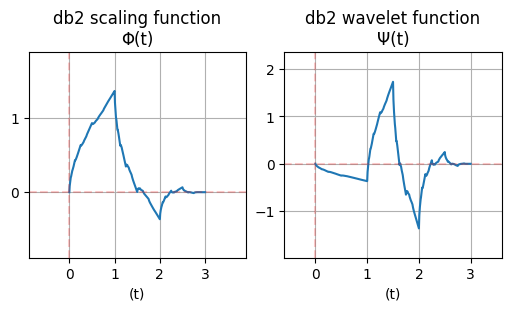

In [17]:
plot_wpt_fun(wpt_fun, (0.3, 0.2), step1=(1, 1), step2=(1, 1), figsize=(5, 3))

In [18]:
img_trans_norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
img_trans_norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [19]:
# Input Image height/width in pixels
in_img_size = int(df_all.iloc[0, 1])

channels = len(df_all.iloc[0, 3])

image_new_size = in_img_size

if image_new_size != in_img_size:
  image_t=v2.Resize(image_new_size)(r_img)
else:
  image_t = r_img

# The height/width of a wpt decomposition in pixels
# note that the wpt decomposition (and not the original image) will be the actual input to the VIT model
wpt_img_size = wpt_dec(image_t, wpt_fun, wpt_level)[1].shape[1]

# The height/width of a patch in pixels (patch is a slice of a WPT decomposition)
patch_size = wpt_img_size

features = ((2**wpt_level)**2) if wpt_slice==None else len(wpt_slice)   # 16 for level 2

# No. of patches(slices) per WPT decomposition
patches_per_dec = (wpt_img_size//patch_size)**2

# Each patch (slice) will be flattened into a row vector of size (3 Channels x Patch_size x Patch_size)
patch_flat_size = (channels) * patch_size**2

# the flattened patch will be passed first through a linear layer with output embed_size
# in this case I will keep the same dimension
embed_size = patch_flat_size

# dim of the last mlp classifier
mlp_dim = embed_size*4#384

# The larger the batch size the faster convergence to the optimum parameters
# The downside is the larger model size and GPU memory consumed
train_batch_size = 1000  # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 1000
test_batch_size = 1000

# We have 2 classes: Real or Fake
num_classes = len(classes)
encoder_depth = 1

# always take care that embed_size is divisible by the number of attention heads
attention_heads = 18

# Whether we want to calculate attention of each patch with only its previous patches (in this case Causal is True)
# or with all (before and after) patches in the sequence (in this case Causal is False)
is_causal = False

print(f'Size of the original image: {in_img_size}x{in_img_size} ')
print(f'Size of the resized image: {image_new_size}x{image_new_size} ')
print(f'Size of the WPT decomposition : {wpt_img_size}x{wpt_img_size}')
print(f'Size of single patch(slice): {patch_size}x{patch_size}')
print(f'Patch flattened vector size: {patch_size}x{patch_size}x{channels} = {patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')
print()
print(f'No. of WPT decompositions of the image: {features}')
print(f'No. of patches per WPT decomposition: {patches_per_dec}')
print(f'Total No of patches : {features}x{patches_per_dec} = {features*patches_per_dec}')

Size of the original image: 32x32 
Size of the resized image: 32x32 
Size of the WPT decomposition : 6x6
Size of single patch(slice): 6x6
Patch flattened vector size: 6x6x3 = 108
Embedding Size: 108
Output MLP size: 432

No. of WPT decompositions of the image: 10
No. of patches per WPT decomposition: 1
Total No of patches : 10x1 = 10


In [20]:
base_lr = 0.1         # Base Learning rate 0.1 for SGD , 0.0001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.001     # Weight decay for Adam

if start_from_model & continue_lr:
    use_lr = checkpoint['running_lr_lst'][-1]
else:
    use_lr = base_lr


loss_algo = CrossEntropyLoss

optimize_algo = SGD  # Adam
optimize_args = {"lr": use_lr,
                 #  "weight_decay": weight_decay ,
                 "momentum": momentum
                 }

schedule_algo = CosineAnnealingLR # ReduceLROnPlateau
schedule_args = {"T_max":n_extra_epochs}#{"factor": 0.5, "mode": "max"}

In [21]:
hyper_parameters = {
    "training_phase": training_phase,
    "model_type": model_type,
    "wpt_fun": wpt_fun,
    "wpt_level": wpt_level,
    "wpt_mode": wpt_mode,
    "wpt_slice": wpt_slice,
    "channels": channels,
    "img_trans_norm_mean": img_trans_norm_mean,
    "img_trans_norm_std": img_trans_norm_std,
    "in_img_size": in_img_size,
    "image_new_size": image_new_size,
    "wpt_img_size": wpt_img_size,
    "patch_size": patch_size,
    "features": features,
    "patches_per_dec": patches_per_dec,
    "patch_flat_size": patch_flat_size,
    "embed_size": embed_size,
    "mlp_dim": mlp_dim,
    "train_batch_size": train_batch_size,
    "valid_batch_size": valid_batch_size,
    "num_classes": num_classes,
    "encoder_depth": encoder_depth,
    "attention_heads": attention_heads,
    "is_causal": is_causal,
    "n_extra_epochs ": n_extra_epochs,
    "base_lr": base_lr,
    "momentum": momentum,
    "weight_decay": weight_decay,
    "loss_algo": loss_algo,
    "optimize_algo": optimize_algo,
    "optimize_args": optimize_args,
    "use_scheduler": use_scheduler,
    "schedule_algo": schedule_algo,
    "schedule_args": schedule_args
}

hyper_parameters

{'training_phase': 2,
 'model_type': 'vit',
 'wpt_fun': 'db2',
 'wpt_level': 3,
 'wpt_mode': 'symmetric',
 'wpt_slice': [0, 1, 4, 16, 18, 24, 26, 32, 34, 36],
 'channels': 3,
 'img_trans_norm_mean': [0.4913997551666284,
  0.48215855929893703,
  0.4465309133731618],
 'img_trans_norm_std': [0.24703225141799082,
  0.24348516474564,
  0.2615878392604963],
 'in_img_size': 32,
 'image_new_size': 32,
 'wpt_img_size': 6,
 'patch_size': 6,
 'features': 10,
 'patches_per_dec': 1,
 'patch_flat_size': 108,
 'embed_size': 108,
 'mlp_dim': 432,
 'train_batch_size': 1000,
 'valid_batch_size': 1000,
 'num_classes': 2,
 'encoder_depth': 1,
 'attention_heads': 18,
 'is_causal': False,
 'n_extra_epochs ': 200,
 'base_lr': 0.1,
 'momentum': 0.9,
 'weight_decay': 0.001,
 'loss_algo': torch.nn.modules.loss.CrossEntropyLoss,
 'optimize_algo': torch.optim.sgd.SGD,
 'optimize_args': {'lr': 0.1, 'momentum': 0.9},
 'use_scheduler': True,
 'schedule_algo': torch.optim.lr_scheduler.CosineAnnealingLR,
 'schedule_ar

In [22]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# replaced the attention mechanism with MHA from Sebastian Raschka

# helpers
def mask(x_size, patches_per_dec, features, heads):

    # patches_per_dec : is the number of patches per each wpt decomposition
    # x_size is the shape of the Transformer (MHA) input, it has the shape:
    # (batch_size, patches"including the first position patch",patch embedding_size)

    # The smallest granularity of mask is a whole WPT decomposition

    a0 = torch.zeros(patches_per_dec, patches_per_dec, dtype=torch.int)
    a1 = torch.ones(patches_per_dec, patches_per_dec, dtype=torch.int)
    a = torch.stack((a0, a1))

    batch_size = x_size[0]
    patches = x_size[1]

    # features

    b = torch.ones(features,  features, dtype=torch.int32).tril(0)
    c = a[b]
    e = rearrange(c, "a b c d -> (a c)(b d)")

    pos_col = torch.ones(patches-1, 1, dtype=torch.int32)
    pos_row = torch.zeros(1, patches, dtype=torch.int32)

    f = torch.concat((pos_col, e), dim=1)
    mask = torch.concat((pos_row, f), dim=0)
    mask[0, 0] = 1

    mask = mask[None, None, :, :]
    mask = mask.repeat(batch_size, heads, 1, 1)
    mask = mask.to(dtype=torch.bool)

    return mask


class WPT2D(nn.Module):
    def __init__(self, wpt_fun, wpt_level, mode, slice):
        super().__init__()
        self.wpt_fun = wpt_fun
        self.wpt_level = wpt_level
        self.mode = mode
        self.slice = slice

    def forward(self, x):

        *_, nodes_tensor = wpt_dec(x, self.wpt_fun, level=self.wpt_level, mode=self.mode, slice=self.slice)

        return nodes_tensor


class Patch_Embed(nn.Module):
    def __init__(self, patch_size, patch_dim, embed_size):
        super().__init__()
        self.patch_embed = nn.Sequential(
            # This rearrangement is suitable for the wavelet packet features
            # torch.Size([200, 16, 3, 32, 32])
            Rearrange('b f c (h p1) (w p2) -> b (f h w) (c p1 p2)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, embed_size),
        )

    def forward(self, x):
        return self.patch_embed(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)


# inspired by Sebstian Raschka with modifications
class MHA(nn.Module):
    def __init__(self, patches_per_dec, features, embed_size, heads, is_causal, dropout):
        super().__init__()
        self.embed_size = embed_size
        self.inner_dim = embed_size*2
        self.heads = heads
        self.dim_per_head = self.inner_dim // self.heads
        self.Wq = nn.Linear(in_features=embed_size, out_features=self.inner_dim)
        self.Wk = nn.Linear(in_features=embed_size, out_features=self.inner_dim)
        self.Wv = nn.Linear(in_features=embed_size, out_features=self.inner_dim)
        self.softmax = nn.Softmax(dim=-1)

        self.dropout = dropout
        self.linear = nn.Linear( in_features=self.inner_dim, out_features=embed_size)
        self.is_causal = is_causal
        self.patches_per_dec = patches_per_dec
        self.features = features

    def forward(self, x):

        attn_bias = torch.zeros(x.size(0), self.heads, x.size(1), x.size(1), dtype=x.dtype).to(device)

        if self.is_causal:
            temp_mask = mask(x.shape, self.patches_per_dec, self.features, self.heads).to(device)
            attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
            attn_bias.to(dtype=x.dtype)

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        
        Q = rearrange(q, 'b s (h d) -> b h s d', h=self.heads, d=self.dim_per_head)
        K = rearrange(k, 'b s (h d) -> b h s d', h=self.heads, d=self.dim_per_head)
        V = rearrange(v, 'b s (h d) -> b h s d', h=self.heads, d=self.dim_per_head)

        scale_factor = self.dim_per_head**0.5

        use_dropout = 0.0 if not self.training else self.dropout

        # Note:

        # # Q(b h s d) . KT(b h d s) ==> b h s s
        QK = Q @ K.transpose(-2, -1) * scale_factor

        if self.is_causal:
            QK_and_bias = QK+attn_bias
            # b h s s ==> b h s s
            weight = self.softmax(QK_and_bias)
        else:
            weight = self.softmax(QK)

        weight_drop = torch.dropout(weight, use_dropout, train=True)

        # # weight(b h s s).V(b h s d) ==> attention (b h s d)
        attention = weight_drop @ V

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention


class Transformer(nn.Module):
    def __init__(self, patches_per_dec, features, embed_size, depth, mlp_dim, heads, is_causal, dropout):
        super().__init__()

        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [PreNorm(embed_size, MHA(patches_per_dec, features, embed_size, heads, is_causal, dropout)),
                     PreNorm(embed_size, FeedForward(embed_size, mlp_dim, dropout=dropout))]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class vit(nn.Module):
    def __init__(self, num_classes, channels, features, slice, patches_per_dec, patch_size, embed_size, wpt_fun, wpt_level, mode, depth, heads, mlp_dim, is_causal, emb_dropout, enc_dropout):

        super().__init__()

        # num_classes: Number of classes to be learned (2 for the binary Deep Fake Identification Problem)
        # channels: Channels of the image (3 for colored images)
        # features: No. of WPT decompositions per an image
        # slice: which WPT decompositions will be considered as input for the model
        # patches_per_dec: No. of patches per a single WPT decomposition 
        # patch_size: the height or width of 2D patch (slice)
        # embed_size: the flattend size for each patch token before entering the encoder stage 
        # wpt_fun: The Wavelet Function
        # wpt_level: The maximum Level to which an Image will be decomposed
        # mode: How WPT will deal with the edges of the image (padding)
        # depth: Number of stacked encoders in the transformer
        # heads: Number of heads in the encoders
        # mlp_dim: size of the last MLP layer after existing the transformer 
        # is_causal: if True then token will not calculate attention with the next (future) tokens in the input sequence  
        # emb_dropout: dropout ratio before entering the transformer (to reduce overfitting)
        # enc_dropout: dropout ratio inside each encoder of the transformer (to reduce overfitting)  

        patch_dim = channels * patch_size**2
        num_patches = patches_per_dec * features

        self.to_wpt2d = WPT2D(wpt_fun, wpt_level, mode, slice)
        self.to_patch_embedding = Patch_Embed(patch_size, patch_dim, embed_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_size))
        
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(patches_per_dec, features, embed_size, depth, mlp_dim, heads, is_causal, enc_dropout)

        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )

    def forward(self, img):

        # First: Output the WPT decompositions of the input image
        img_wpt = self.to_wpt2d(img)

        # Second: slice every WPT decomposition into patches(slices)
        x = self.to_patch_embedding(img_wpt)

        # Third: add class token and positional embedding

            # input x.shape: (batch_size , num_patches , embed_size)
        b, *_ = x.shape
        
            # cls_token.shape: (1 , 1 , embed_size)
            # cls_tokens.shape: (batch_size , 1 , embed_size)
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        
            # new x.shape: (batch_size , num_patches + 1 , embed_size)
        x = torch.cat((cls_tokens, x), dim=1)

            # pos_embedding.shape: (batch_size , num_patches + 1 , embed_size)
        x += self.pos_embedding

        # Fourth: transformer 
        x = self.dropout(x)
        x = self.transformer(x)

        x = x[:, 0]  # x.mean(dim=1)

        x = self.to_latent(x)

        # Fifth: output MLP Layer 
        out = self.mlp_head(x)

        return out 

In [23]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):

        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):

        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 5], dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [24]:
if image_new_size != in_img_size:
    transform_train = transforms.Compose([
        v2.Resize(size=image_new_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

    transform_valid = transforms.Compose([
        v2.Resize(size=image_new_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

else:
    transform_train = transforms.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

    transform_valid = transforms.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

In [25]:
# Define the dataset object and configure the Data Loader

train_set = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set = Images_Dataset(df_val, transform_valid)

valid_loader = DataLoader(dataset=valid_set,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [26]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 100
Total number of validation batches: 20


In [27]:
sample_imgt_bch, label_bch = next(iter(train_loader))

In [28]:
print(f"Batch of Images Shape: {sample_imgt_bch.size()}")
print(f"Batch of Labels Shape: {label_bch.size()}")

Batch of Images Shape: torch.Size([1000, 3, 32, 32])
Batch of Labels Shape: torch.Size([1000])


In [29]:
sample_img_idx = 12

sample_img = sample_imgt_bch[sample_img_idx, :, :, :]
sample_img.shape

torch.Size([3, 32, 32])

In [30]:
_, nodes, _ = wpt_dec(img=sample_img, wavelet_fun=wpt_fun, level=wpt_level, mode=wpt_mode, slice=wpt_slice)

In [31]:
sample_img_a = norm_to_plot(sample_img)
sample_img_a.shape

(32, 32, 3)

Text(0.5, 1.0, 'Label: Fake')

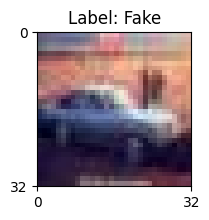

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

n = sample_img_a.shape[0]
extent = [0, n, n, 0]

ax.imshow(norm_to_plot(sample_img_a), extent=extent)
ax.set(xticks=np.arange(0, sample_img_a.shape[1]+1, step=32),
       yticks=np.arange(0, sample_img_a.shape[0]+1, step=32))
ax.set_title(
    f'Label: {"Real" if label_bch[sample_img_idx].item()==1 else "Fake"}')

In [33]:
print(sample_img.shape)

torch.Size([3, 32, 32])


/home/osmahus/Code/DF/Final_V2.0/WPT-ViT/research_code/src/helpers/WaveletPacket.py:42: RuntimeWarning: invalid value encountered in divide
  img_out = (img-img.min())/(img.max()-img.min())
/home/osmahus/pytVenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)
/home/osmahus/pytVenv/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


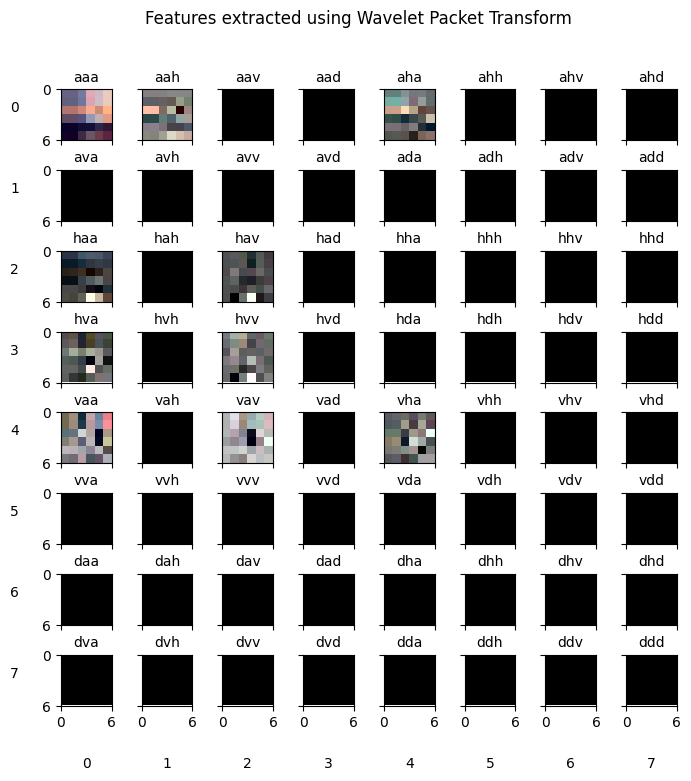

In [34]:
plot_wpt_nodes(sample_img, wpt_fun, wpt_level, setticks=6, slice=wpt_slice, figsize=(8, 8))

Shape of the image patches matrix:  (1, 1, 6, 6, 3)


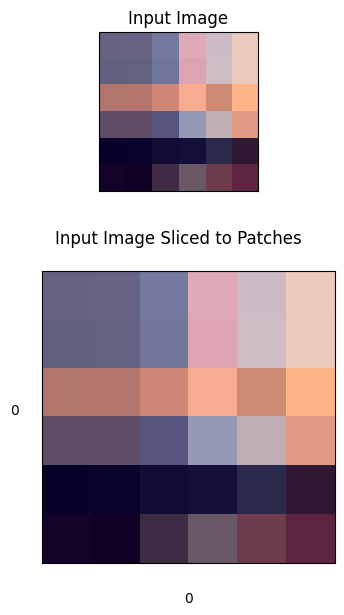

In [35]:
img_plot(nodes[0, :, :, :], slice_width=patch_size, figsize=(8, 6), setticks1=None, setticks2=None, axes_pad=0.15)

Shape of the image patches matrix:  (1, 1, 6, 6, 3)


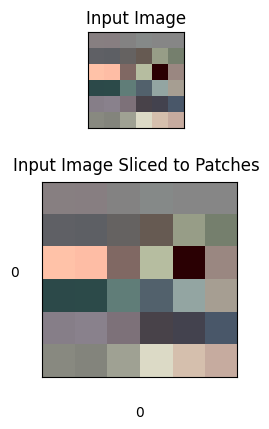

In [36]:
if wpt_level != 0:
    img_plot(nodes[1, :, :, :], slice_width=patch_size, figsize=(3, 4), setticks1=None, setticks2=None, axes_pad=0.15)

In [37]:
if model_type == "vit":
    model = vit(
        num_classes=num_classes,
        channels=channels,
        features=features,
        slice=wpt_slice,
        patches_per_dec=patches_per_dec,
        patch_size=patch_size,
        embed_size=embed_size,
        wpt_fun=wpt_fun,
        wpt_level=wpt_level,
        mode=wpt_mode,
        depth=encoder_depth,
        heads=attention_heads,
        mlp_dim=mlp_dim,
        is_causal=is_causal,
        emb_dropout=0.1,
        enc_dropout=0.1,
    )
else:
    raise ValueError(
        "You must set the model_type variable to any of: vit ,....")

In [38]:
summary(model=model,
        input_size=sample_imgt_bch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
vit (vit)                                          [1000, 3, 32, 32]    [1000, 2]            1,296                True
├─WPT2D (to_wpt2d)                                 [1000, 3, 32, 32]    [1000, 10, 3, 6, 6]  --                   --
├─Patch_Embed (to_patch_embedding)                 [1000, 10, 3, 6, 6]  [1000, 10, 108]      --                   True
│    └─Sequential (patch_embed)                    [1000, 10, 3, 6, 6]  [1000, 10, 108]      --                   True
│    │    └─Rearrange (0)                          [1000, 10, 3, 6, 6]  [1000, 10, 108]      --                   --
│    │    └─Linear (1)                             [1000, 10, 108]      [1000, 10, 108]      11,772               True
├─Dropout (dropout)                                [1000, 11, 108]      [1000, 11, 108]      --                   --
├─Transformer (transformer)                      

In [39]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [40]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    if checkpoint['optimizer_lst'][-1] == optimize_algo:
        optimizer.load_state_dict(checkpoint['optimizer'])

    best_acc = checkpoint['best_acc']
    epoch_lst = checkpoint['epoch_lst']
    tr_loss_lst = checkpoint['tr_loss_lst']
    tr_acc_lst = checkpoint['tr_acc_lst']
    val_loss_lst = checkpoint['val_loss_lst']
    val_acc_lst = checkpoint['val_acc_lst']
    optimizer_lst = checkpoint['optimizer_lst']
    running_lr_lst = checkpoint['running_lr_lst']
    training_phase_lst = checkpoint['training_phase_lst']
    hyper_parameters_lst = checkpoint['hyper_parameters_lst']
    accumulate_duration_lst = checkpoint['accumulate_duration_lst']
    model_file_name_lst = checkpoint['model_file_name_lst']

else:
    
    best_acc = 0
    epoch_lst = []
    tr_loss_lst = []
    tr_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []
    optimizer_lst = []
    running_lr_lst = []
    training_phase_lst = []
    hyper_parameters_lst = []
    accumulate_duration_lst = []
    model_file_name_lst = []

In [41]:
training_start_time = time.time()

model.to(device)
for epoch in range(start_epoch, end_epoch):
    epoch_start_time = time.time()

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0
    running_lr = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (*_, inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path
        loss.backward()

        running_lr += optimizer.param_groups[-1]['lr']

        # Optimizer Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total
        avg_running_lr = running_lr/(batch_idx+1)

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (*_, inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)
    ##########################################################

    epoch_end_time = time.time()

    epoch_duration = epoch_end_time-epoch_start_time
    epoch_duration_str = time.strftime("%H:%M:%S", time.gmtime(epoch_duration))
    previous_duration = accumulate_duration_lst[-1] if len(accumulate_duration_lst) != 0 else 0
    accumulate_duration = epoch_duration+previous_duration
    accumulate_duration_str = time.strftime("%H:%M:%S", time.gmtime(accumulate_duration))
    print(f'epoch duration(H:M:S):- {epoch_duration_str}   accumulate duration(H:M:S):- {accumulate_duration_str}')

    model_file_name = f'{model_code}_ph{training_phase}_ep{epoch+1}_acc{avg_val_accuracy:.2f}'

    ##########################################################

    epoch_lst.append(epoch+1)
    tr_loss_lst.append(avg_tr_loss)
    tr_acc_lst.append(avg_tr_accuracy)
    val_loss_lst.append(avg_val_loss)
    val_acc_lst.append(avg_val_accuracy)
    optimizer_lst.append(type(optimizer).__name__)
    running_lr_lst.append(avg_running_lr)
    training_phase_lst.append(training_phase)
    hyper_parameters_lst.append(hyper_parameters)
    accumulate_duration_lst.append(accumulate_duration)
    model_file_name_lst.append(model_file_name)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving...')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "best_acc": best_acc,
                 "epoch_lst": epoch_lst,
                 "tr_loss_lst": tr_loss_lst,
                 "tr_acc_lst": tr_acc_lst,
                 "val_loss_lst": val_loss_lst,
                 "val_acc_lst": val_acc_lst,
                 "optimizer_lst": optimizer_lst,
                 "running_lr_lst": running_lr_lst,
                 "training_phase_lst": training_phase_lst,
                 "hyper_parameters_lst": hyper_parameters_lst,
                 "accumulate_duration_lst": accumulate_duration_lst,
                 "model_file_name_lst":model_file_name_lst
                 }
        torch.save(state, model_state_path + model_file_name)

    ##########################################################

    if use_scheduler:
        scheduler.step(val_acc_lst[-1])  # step scheduling
    print()


training_end_time = time.time()
total_duration = training_end_time-training_start_time
total_duration_str = time.strftime("%H:%M:%S", time.gmtime(total_duration))
print()
print(f'Total Training Time(H:M:S):- {total_duration_str}')

Valid--Epoch [181/380]: 100%|██████████| 20/20 [00:01<00:00, 17.44it/s, acc=91.5, loss=0.214]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:25:33




/home/osmahus/pytVenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Valid--Epoch [182/380]: 100%|██████████| 20/20 [00:01<00:00, 16.81it/s, acc=91.5, loss=0.221]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:25:39




Valid--Epoch [183/380]: 100%|██████████| 20/20 [00:01<00:00, 16.08it/s, acc=91.5, loss=0.215]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:25:46




Valid--Epoch [184/380]: 100%|██████████| 20/20 [00:01<00:00, 17.39it/s, acc=91.4, loss=0.227]


epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:25:53



Valid--Epoch [185/380]: 100%|██████████| 20/20 [00:01<00:00, 14.91it/s, acc=91.8, loss=0.213]


epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:26:00
Saving...



Valid--Epoch [186/380]: 100%|██████████| 20/20 [00:01<00:00, 17.07it/s, acc=91.6, loss=0.214]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:26:07




Valid--Epoch [187/380]: 100%|██████████| 20/20 [00:01<00:00, 17.20it/s, acc=91.7, loss=0.214]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:26:14




Valid--Epoch [188/380]: 100%|██████████| 20/20 [00:01<00:00, 17.58it/s, acc=91.5, loss=0.221]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:26:21




Valid--Epoch [189/380]: 100%|██████████| 20/20 [00:01<00:00, 17.23it/s, acc=91.8, loss=0.215]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:26:28
Saving...




Valid--Epoch [190/380]: 100%|██████████| 20/20 [00:01<00:00, 17.53it/s, acc=91.8, loss=0.216]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:26:35




Valid--Epoch [191/380]: 100%|██████████| 20/20 [00:01<00:00, 16.72it/s, acc=91.5, loss=0.222]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:26:42




Valid--Epoch [192/380]: 100%|██████████| 20/20 [00:01<00:00, 17.19it/s, acc=91.7, loss=0.218]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:26:49




Valid--Epoch [193/380]: 100%|██████████| 20/20 [00:01<00:00, 13.63it/s, acc=91.7, loss=0.219]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:26:56




Valid--Epoch [194/380]: 100%|██████████| 20/20 [00:01<00:00, 16.77it/s, acc=91.5, loss=0.218]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:04




Valid--Epoch [195/380]: 100%|██████████| 20/20 [00:01<00:00, 16.81it/s, acc=91.6, loss=0.218]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:11




Valid--Epoch [196/380]: 100%|██████████| 20/20 [00:01<00:00, 16.13it/s, acc=91.8, loss=0.213]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:27:18




Valid--Epoch [197/380]: 100%|██████████| 20/20 [00:01<00:00, 16.83it/s, acc=91.4, loss=0.228]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:25




Valid--Epoch [198/380]: 100%|██████████| 20/20 [00:01<00:00, 16.25it/s, acc=91.6, loss=0.224]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:32




Valid--Epoch [199/380]: 100%|██████████| 20/20 [00:01<00:00, 16.14it/s, acc=91.6, loss=0.221]


epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:39



Valid--Epoch [200/380]: 100%|██████████| 20/20 [00:01<00:00, 16.43it/s, acc=91.8, loss=0.218]


epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:47



Valid--Epoch [201/380]: 100%|██████████| 20/20 [00:01<00:00, 17.69it/s, acc=91.7, loss=0.221]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:27:54




Valid--Epoch [202/380]: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s, acc=91.7, loss=0.217]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:01




Valid--Epoch [203/380]: 100%|██████████| 20/20 [00:01<00:00, 16.57it/s, acc=91.4, loss=0.222]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:09




Valid--Epoch [204/380]: 100%|██████████| 20/20 [00:01<00:00, 17.14it/s, acc=91.7, loss=0.219]

epoch duration(H:M:S):- 00:00:06   accumulate duration(H:M:S):- 00:28:16




Valid--Epoch [205/380]: 100%|██████████| 20/20 [00:01<00:00, 16.67it/s, acc=91.7, loss=0.219]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:23




Valid--Epoch [206/380]: 100%|██████████| 20/20 [00:01<00:00, 15.81it/s, acc=91.7, loss=0.224]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:30




Valid--Epoch [207/380]: 100%|██████████| 20/20 [00:01<00:00, 16.67it/s, acc=91.8, loss=0.22] 

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:38




Valid--Epoch [208/380]: 100%|██████████| 20/20 [00:01<00:00, 16.43it/s, acc=91.5, loss=0.228]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:45




Valid--Epoch [209/380]: 100%|██████████| 20/20 [00:01<00:00, 16.08it/s, acc=91.8, loss=0.218]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:52




Valid--Epoch [210/380]: 100%|██████████| 20/20 [00:01<00:00, 16.93it/s, acc=91.8, loss=0.218]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:28:59




Valid--Epoch [211/380]: 100%|██████████| 20/20 [00:01<00:00, 16.11it/s, acc=91.8, loss=0.222]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:29:06




Valid--Epoch [212/380]: 100%|██████████| 20/20 [00:01<00:00, 15.06it/s, acc=91.6, loss=0.223]


epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:29:13



Valid--Epoch [213/380]: 100%|██████████| 20/20 [00:01<00:00, 16.62it/s, acc=91.8, loss=0.218]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:29:21




Valid--Epoch [214/380]: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s, acc=91.8, loss=0.224]


epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:29:28



Valid--Epoch [215/380]: 100%|██████████| 20/20 [00:01<00:00, 15.85it/s, acc=91.9, loss=0.222]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:29:36
Saving...




Valid--Epoch [216/380]: 100%|██████████| 20/20 [00:01<00:00, 11.71it/s, acc=91.7, loss=0.222]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:29:46




Valid--Epoch [217/380]: 100%|██████████| 20/20 [00:01<00:00, 11.78it/s, acc=91.4, loss=0.226]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:29:57




Valid--Epoch [218/380]: 100%|██████████| 20/20 [00:01<00:00, 11.51it/s, acc=91.9, loss=0.221]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:30:07




Valid--Epoch [219/380]: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s, acc=91.8, loss=0.22] 

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:30:18




Valid--Epoch [220/380]: 100%|██████████| 20/20 [00:01<00:00, 13.51it/s, acc=91.7, loss=0.223]


epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:30:27



Valid--Epoch [221/380]: 100%|██████████| 20/20 [00:01<00:00, 11.73it/s, acc=91.7, loss=0.227]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:30:37




Valid--Epoch [222/380]: 100%|██████████| 20/20 [00:01<00:00, 12.22it/s, acc=91.8, loss=0.222]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:30:47




Valid--Epoch [223/380]: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s, acc=91.8, loss=0.218]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:30:58




Valid--Epoch [224/380]: 100%|██████████| 20/20 [00:01<00:00, 11.27it/s, acc=91.6, loss=0.224]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:31:08




Valid--Epoch [225/380]: 100%|██████████| 20/20 [00:01<00:00, 11.68it/s, acc=91.5, loss=0.224]


epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:31:19



Valid--Epoch [226/380]: 100%|██████████| 20/20 [00:01<00:00, 11.77it/s, acc=91.7, loss=0.226]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:31:29




Valid--Epoch [227/380]: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s, acc=91.9, loss=0.226]

epoch duration(H:M:S):- 00:00:11   accumulate duration(H:M:S):- 00:31:41




Valid--Epoch [228/380]: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s, acc=91.8, loss=0.222]

epoch duration(H:M:S):- 00:00:11   accumulate duration(H:M:S):- 00:31:52




Valid--Epoch [229/380]: 100%|██████████| 20/20 [00:01<00:00, 11.26it/s, acc=91.9, loss=0.221]


epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:32:03
Saving...



Valid--Epoch [230/380]: 100%|██████████| 20/20 [00:01<00:00, 11.53it/s, acc=91.8, loss=0.22] 

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:32:13




Valid--Epoch [231/380]: 100%|██████████| 20/20 [00:01<00:00, 10.84it/s, acc=91.7, loss=0.222]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:32:24




Valid--Epoch [232/380]: 100%|██████████| 20/20 [00:02<00:00,  7.68it/s, acc=91.9, loss=0.221]


epoch duration(H:M:S):- 00:00:11   accumulate duration(H:M:S):- 00:32:36
Saving...



Valid--Epoch [233/380]: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s, acc=91.9, loss=0.223]

epoch duration(H:M:S):- 00:00:11   accumulate duration(H:M:S):- 00:32:47




Valid--Epoch [234/380]: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s, acc=91.5, loss=0.231]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:32:57




Valid--Epoch [235/380]: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s, acc=91.9, loss=0.225]

epoch duration(H:M:S):- 00:00:10   accumulate duration(H:M:S):- 00:33:07
Saving...




Valid--Epoch [236/380]: 100%|██████████| 20/20 [00:01<00:00, 15.37it/s, acc=91.9, loss=0.217]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:33:16




Valid--Epoch [237/380]: 100%|██████████| 20/20 [00:01<00:00, 15.16it/s, acc=91.7, loss=0.226]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:33:24




Valid--Epoch [238/380]: 100%|██████████| 20/20 [00:01<00:00, 15.81it/s, acc=91.6, loss=0.228]


epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:33:32



Valid--Epoch [239/380]: 100%|██████████| 20/20 [00:01<00:00, 15.26it/s, acc=91.8, loss=0.228]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:33:39




Valid--Epoch [240/380]: 100%|██████████| 20/20 [00:01<00:00, 14.52it/s, acc=91.8, loss=0.222]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:33:47




Valid--Epoch [241/380]: 100%|██████████| 20/20 [00:01<00:00, 15.16it/s, acc=92.1, loss=0.221]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:33:55
Saving...




Valid--Epoch [242/380]: 100%|██████████| 20/20 [00:01<00:00, 15.62it/s, acc=92.1, loss=0.225]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:34:03




Valid--Epoch [243/380]: 100%|██████████| 20/20 [00:01<00:00, 15.20it/s, acc=91.5, loss=0.234]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:34:11




Valid--Epoch [244/380]: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s, acc=91.8, loss=0.229]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:34:19




Valid--Epoch [245/380]: 100%|██████████| 20/20 [00:01<00:00, 14.89it/s, acc=91.9, loss=0.218]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:34:27




Valid--Epoch [246/380]: 100%|██████████| 20/20 [00:01<00:00, 15.57it/s, acc=91.5, loss=0.231]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:34:36




Valid--Epoch [247/380]: 100%|██████████| 20/20 [00:01<00:00, 15.16it/s, acc=91.7, loss=0.225]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:34:44




Valid--Epoch [248/380]: 100%|██████████| 20/20 [00:01<00:00, 11.40it/s, acc=91.9, loss=0.236]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:34:52




Valid--Epoch [249/380]: 100%|██████████| 20/20 [00:01<00:00, 13.65it/s, acc=91.8, loss=0.229]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:35:00




Valid--Epoch [250/380]: 100%|██████████| 20/20 [00:01<00:00, 14.10it/s, acc=91.8, loss=0.232]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:35:09




Valid--Epoch [251/380]: 100%|██████████| 20/20 [00:01<00:00, 14.65it/s, acc=91.8, loss=0.224]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:35:18




Valid--Epoch [252/380]: 100%|██████████| 20/20 [00:01<00:00, 14.96it/s, acc=91.9, loss=0.23] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:35:26




Valid--Epoch [253/380]: 100%|██████████| 20/20 [00:01<00:00, 15.26it/s, acc=91.8, loss=0.231]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:35:33




Valid--Epoch [254/380]: 100%|██████████| 20/20 [00:01<00:00, 14.91it/s, acc=91.9, loss=0.225]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:35:41




Valid--Epoch [255/380]: 100%|██████████| 20/20 [00:01<00:00, 15.60it/s, acc=91.8, loss=0.235]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:35:50




Valid--Epoch [256/380]: 100%|██████████| 20/20 [00:01<00:00, 14.89it/s, acc=91.8, loss=0.232]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:35:58




Valid--Epoch [257/380]: 100%|██████████| 20/20 [00:01<00:00, 15.60it/s, acc=91.7, loss=0.229]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:06




Valid--Epoch [258/380]: 100%|██████████| 20/20 [00:01<00:00, 15.25it/s, acc=91.8, loss=0.232]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:13




Valid--Epoch [259/380]: 100%|██████████| 20/20 [00:01<00:00, 15.34it/s, acc=91.9, loss=0.233]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:21




Valid--Epoch [260/380]: 100%|██████████| 20/20 [00:01<00:00, 15.94it/s, acc=91.9, loss=0.233]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:29




Valid--Epoch [261/380]: 100%|██████████| 20/20 [00:01<00:00, 15.27it/s, acc=91.8, loss=0.231]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:37




Valid--Epoch [262/380]: 100%|██████████| 20/20 [00:01<00:00, 15.47it/s, acc=91.8, loss=0.241]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:45




Valid--Epoch [263/380]: 100%|██████████| 20/20 [00:01<00:00, 14.26it/s, acc=92.1, loss=0.227]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:36:53
Saving...




Valid--Epoch [264/380]: 100%|██████████| 20/20 [00:01<00:00, 11.84it/s, acc=92, loss=0.231]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:01




Valid--Epoch [265/380]: 100%|██████████| 20/20 [00:01<00:00, 14.45it/s, acc=91.8, loss=0.231]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:10




Valid--Epoch [266/380]: 100%|██████████| 20/20 [00:01<00:00, 13.17it/s, acc=91.9, loss=0.233]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:18




Valid--Epoch [267/380]: 100%|██████████| 20/20 [00:01<00:00, 15.69it/s, acc=91.6, loss=0.24] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:27




Valid--Epoch [268/380]: 100%|██████████| 20/20 [00:01<00:00, 14.07it/s, acc=91.8, loss=0.234]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:35




Valid--Epoch [269/380]: 100%|██████████| 20/20 [00:01<00:00, 14.27it/s, acc=91.9, loss=0.236]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:44




Valid--Epoch [270/380]: 100%|██████████| 20/20 [00:01<00:00, 14.74it/s, acc=92, loss=0.236]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:37:52




Valid--Epoch [271/380]: 100%|██████████| 20/20 [00:01<00:00, 13.88it/s, acc=92, loss=0.237]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:38:00




Valid--Epoch [272/380]: 100%|██████████| 20/20 [00:01<00:00, 14.03it/s, acc=91.8, loss=0.241]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:38:09




Valid--Epoch [273/380]: 100%|██████████| 20/20 [00:01<00:00, 14.75it/s, acc=91.8, loss=0.238]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:38:17




Valid--Epoch [274/380]: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s, acc=92, loss=0.241]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:38:26




Valid--Epoch [275/380]: 100%|██████████| 20/20 [00:01<00:00, 14.40it/s, acc=91.8, loss=0.243]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:38:35




Valid--Epoch [276/380]: 100%|██████████| 20/20 [00:01<00:00, 13.95it/s, acc=91.8, loss=0.237]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:38:44




Valid--Epoch [277/380]: 100%|██████████| 20/20 [00:01<00:00, 15.71it/s, acc=91.8, loss=0.243]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:38:51




Valid--Epoch [278/380]: 100%|██████████| 20/20 [00:01<00:00, 15.00it/s, acc=91.9, loss=0.238]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:39:00




Valid--Epoch [279/380]: 100%|██████████| 20/20 [00:01<00:00, 13.43it/s, acc=91.7, loss=0.242]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:39:08




Valid--Epoch [280/380]: 100%|██████████| 20/20 [00:01<00:00, 14.25it/s, acc=91.9, loss=0.235]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:39:17




Valid--Epoch [281/380]: 100%|██████████| 20/20 [00:01<00:00, 14.03it/s, acc=91.8, loss=0.243]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:39:25




Valid--Epoch [282/380]: 100%|██████████| 20/20 [00:01<00:00, 13.60it/s, acc=91.8, loss=0.24] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:39:33




Valid--Epoch [283/380]: 100%|██████████| 20/20 [00:01<00:00, 14.26it/s, acc=91.6, loss=0.246]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:39:41




Valid--Epoch [284/380]: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s, acc=91.8, loss=0.248]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:39:50




Valid--Epoch [285/380]: 100%|██████████| 20/20 [00:01<00:00, 14.72it/s, acc=91.7, loss=0.243]


epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:39:58



Valid--Epoch [286/380]: 100%|██████████| 20/20 [00:01<00:00, 13.53it/s, acc=92.2, loss=0.242]


epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:07
Saving...



Valid--Epoch [287/380]: 100%|██████████| 20/20 [00:01<00:00, 14.59it/s, acc=91.8, loss=0.241]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:15




Valid--Epoch [288/380]: 100%|██████████| 20/20 [00:01<00:00, 13.47it/s, acc=91.9, loss=0.237]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:24




Valid--Epoch [289/380]: 100%|██████████| 20/20 [00:01<00:00, 14.89it/s, acc=91.5, loss=0.243]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:32




Valid--Epoch [290/380]: 100%|██████████| 20/20 [00:01<00:00, 14.12it/s, acc=91.9, loss=0.244]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:41




Valid--Epoch [291/380]: 100%|██████████| 20/20 [00:01<00:00, 13.47it/s, acc=92, loss=0.247]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:49




Valid--Epoch [292/380]: 100%|██████████| 20/20 [00:01<00:00, 14.95it/s, acc=91.7, loss=0.248]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:40:57




Valid--Epoch [293/380]: 100%|██████████| 20/20 [00:01<00:00, 13.47it/s, acc=91.9, loss=0.243]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:41:05




Valid--Epoch [294/380]: 100%|██████████| 20/20 [00:01<00:00, 14.20it/s, acc=91.8, loss=0.251]


epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:41:14



Valid--Epoch [295/380]: 100%|██████████| 20/20 [00:01<00:00, 15.25it/s, acc=91.8, loss=0.245]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:41:22




Valid--Epoch [296/380]: 100%|██████████| 20/20 [00:01<00:00, 15.10it/s, acc=91.5, loss=0.255]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:41:30




Valid--Epoch [297/380]: 100%|██████████| 20/20 [00:01<00:00, 14.26it/s, acc=91.8, loss=0.246]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:41:38




Valid--Epoch [298/380]: 100%|██████████| 20/20 [00:01<00:00, 11.85it/s, acc=92, loss=0.242]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:41:47




Valid--Epoch [299/380]: 100%|██████████| 20/20 [00:01<00:00, 11.64it/s, acc=91.5, loss=0.25] 

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:41:56




Valid--Epoch [300/380]: 100%|██████████| 20/20 [00:01<00:00, 14.18it/s, acc=92, loss=0.244]  


epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:05



Valid--Epoch [301/380]: 100%|██████████| 20/20 [00:01<00:00, 15.08it/s, acc=92, loss=0.244]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:13




Valid--Epoch [302/380]: 100%|██████████| 20/20 [00:01<00:00, 13.26it/s, acc=91.8, loss=0.253]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:22




Valid--Epoch [303/380]: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, acc=91.8, loss=0.248]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:30




Valid--Epoch [304/380]: 100%|██████████| 20/20 [00:01<00:00, 14.61it/s, acc=92, loss=0.246]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:38




Valid--Epoch [305/380]: 100%|██████████| 20/20 [00:01<00:00, 14.72it/s, acc=92.1, loss=0.242]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:46




Valid--Epoch [306/380]: 100%|██████████| 20/20 [00:01<00:00, 13.72it/s, acc=91.9, loss=0.247]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:42:55




Valid--Epoch [307/380]: 100%|██████████| 20/20 [00:01<00:00, 14.38it/s, acc=91.9, loss=0.248]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:43:03




Valid--Epoch [308/380]: 100%|██████████| 20/20 [00:01<00:00, 14.86it/s, acc=92, loss=0.245]  

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:43:12




Valid--Epoch [309/380]: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s, acc=91.7, loss=0.251]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:43:21




Valid--Epoch [310/380]: 100%|██████████| 20/20 [00:01<00:00, 14.43it/s, acc=91.7, loss=0.258]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:43:29




Valid--Epoch [311/380]: 100%|██████████| 20/20 [00:01<00:00, 15.02it/s, acc=92, loss=0.253]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:43:37




Valid--Epoch [312/380]: 100%|██████████| 20/20 [00:01<00:00, 12.25it/s, acc=91.8, loss=0.253]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:43:46




Valid--Epoch [313/380]: 100%|██████████| 20/20 [00:01<00:00, 13.52it/s, acc=91.6, loss=0.262]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:43:55




Valid--Epoch [314/380]: 100%|██████████| 20/20 [00:01<00:00, 12.69it/s, acc=91.7, loss=0.256]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:44:04




Valid--Epoch [315/380]: 100%|██████████| 20/20 [00:01<00:00, 11.79it/s, acc=91.7, loss=0.249]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:44:13




Valid--Epoch [316/380]: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s, acc=91.8, loss=0.257]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:44:22




Valid--Epoch [317/380]: 100%|██████████| 20/20 [00:01<00:00, 13.84it/s, acc=91.8, loss=0.254]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:44:30




Valid--Epoch [318/380]: 100%|██████████| 20/20 [00:01<00:00, 15.56it/s, acc=91.9, loss=0.254]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:44:38




Valid--Epoch [319/380]: 100%|██████████| 20/20 [00:01<00:00, 13.31it/s, acc=91.8, loss=0.255]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:44:46




Valid--Epoch [320/380]: 100%|██████████| 20/20 [00:01<00:00, 14.89it/s, acc=91.9, loss=0.257]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:44:55




Valid--Epoch [321/380]: 100%|██████████| 20/20 [00:01<00:00, 14.60it/s, acc=91.7, loss=0.256]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:45:03




Valid--Epoch [322/380]: 100%|██████████| 20/20 [00:01<00:00, 13.51it/s, acc=91.8, loss=0.246]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:45:12




Valid--Epoch [323/380]: 100%|██████████| 20/20 [00:01<00:00, 14.15it/s, acc=91.5, loss=0.278]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:45:20




Valid--Epoch [324/380]: 100%|██████████| 20/20 [00:01<00:00, 14.28it/s, acc=91.9, loss=0.262]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:45:28




Valid--Epoch [325/380]: 100%|██████████| 20/20 [00:01<00:00, 14.81it/s, acc=91.8, loss=0.256]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:45:37




Valid--Epoch [326/380]: 100%|██████████| 20/20 [00:01<00:00, 13.47it/s, acc=91.6, loss=0.265]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:45:45




Valid--Epoch [327/380]: 100%|██████████| 20/20 [00:01<00:00, 13.19it/s, acc=91.6, loss=0.253]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:45:54




Valid--Epoch [328/380]: 100%|██████████| 20/20 [00:01<00:00, 13.99it/s, acc=91.9, loss=0.263]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:46:03




Valid--Epoch [329/380]: 100%|██████████| 20/20 [00:01<00:00, 14.76it/s, acc=91.9, loss=0.252]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:46:12




Valid--Epoch [330/380]: 100%|██████████| 20/20 [00:01<00:00, 14.65it/s, acc=91.8, loss=0.267]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:46:20




Valid--Epoch [331/380]: 100%|██████████| 20/20 [00:01<00:00, 14.70it/s, acc=91.7, loss=0.265]


epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:46:29



Valid--Epoch [332/380]: 100%|██████████| 20/20 [00:01<00:00, 15.62it/s, acc=91.7, loss=0.251]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:46:37




Valid--Epoch [333/380]: 100%|██████████| 20/20 [00:01<00:00, 15.16it/s, acc=91.8, loss=0.259]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:46:45




Valid--Epoch [334/380]: 100%|██████████| 20/20 [00:01<00:00, 14.79it/s, acc=91.8, loss=0.262]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:46:53




Valid--Epoch [335/380]: 100%|██████████| 20/20 [00:01<00:00, 15.11it/s, acc=91.7, loss=0.262]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:47:01




Valid--Epoch [336/380]: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s, acc=91.8, loss=0.261]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:47:09




Valid--Epoch [337/380]: 100%|██████████| 20/20 [00:01<00:00, 15.68it/s, acc=91.7, loss=0.26] 

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:47:17




Valid--Epoch [338/380]: 100%|██████████| 20/20 [00:01<00:00, 15.44it/s, acc=91.8, loss=0.264]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:47:25




Valid--Epoch [339/380]: 100%|██████████| 20/20 [00:01<00:00, 13.69it/s, acc=92, loss=0.26]   

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:47:33




Valid--Epoch [340/380]: 100%|██████████| 20/20 [00:01<00:00, 15.15it/s, acc=91.6, loss=0.271]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:47:41




Valid--Epoch [341/380]: 100%|██████████| 20/20 [00:01<00:00, 15.52it/s, acc=91.6, loss=0.267]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:47:49




Valid--Epoch [342/380]: 100%|██████████| 20/20 [00:01<00:00, 15.13it/s, acc=91.8, loss=0.265]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:47:57




Valid--Epoch [343/380]: 100%|██████████| 20/20 [00:01<00:00, 14.91it/s, acc=92, loss=0.255]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:48:05




Valid--Epoch [344/380]: 100%|██████████| 20/20 [00:01<00:00, 14.30it/s, acc=91.8, loss=0.263]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:48:13




Valid--Epoch [345/380]: 100%|██████████| 20/20 [00:01<00:00, 15.86it/s, acc=91.6, loss=0.267]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:48:21




Valid--Epoch [346/380]: 100%|██████████| 20/20 [00:01<00:00, 15.12it/s, acc=91.7, loss=0.265]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:48:29




Valid--Epoch [347/380]: 100%|██████████| 20/20 [00:01<00:00, 15.49it/s, acc=91.9, loss=0.269]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:48:38




Valid--Epoch [348/380]: 100%|██████████| 20/20 [00:01<00:00, 15.37it/s, acc=91.9, loss=0.254]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:48:45




Valid--Epoch [349/380]: 100%|██████████| 20/20 [00:01<00:00, 15.48it/s, acc=91.8, loss=0.27] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:48:54




Valid--Epoch [350/380]: 100%|██████████| 20/20 [00:01<00:00, 14.46it/s, acc=91.9, loss=0.265]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:49:02




Valid--Epoch [351/380]: 100%|██████████| 20/20 [00:01<00:00, 14.30it/s, acc=91.9, loss=0.267]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:49:10




Valid--Epoch [352/380]: 100%|██████████| 20/20 [00:01<00:00, 15.09it/s, acc=91.7, loss=0.266]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:49:19




Valid--Epoch [353/380]: 100%|██████████| 20/20 [00:01<00:00, 15.25it/s, acc=91.6, loss=0.277]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:49:26




Valid--Epoch [354/380]: 100%|██████████| 20/20 [00:01<00:00, 14.40it/s, acc=91.5, loss=0.272]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:49:35




Valid--Epoch [355/380]: 100%|██████████| 20/20 [00:01<00:00, 15.31it/s, acc=91.8, loss=0.266]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:49:43




Valid--Epoch [356/380]: 100%|██████████| 20/20 [00:01<00:00, 15.44it/s, acc=91.7, loss=0.275]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:49:51




Valid--Epoch [357/380]: 100%|██████████| 20/20 [00:01<00:00, 15.03it/s, acc=91.6, loss=0.27] 

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:49:59




Valid--Epoch [358/380]: 100%|██████████| 20/20 [00:01<00:00, 14.69it/s, acc=91.6, loss=0.278]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:50:07




Valid--Epoch [359/380]: 100%|██████████| 20/20 [00:01<00:00, 15.40it/s, acc=91.9, loss=0.267]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:50:15




Valid--Epoch [360/380]: 100%|██████████| 20/20 [00:01<00:00, 15.10it/s, acc=91.8, loss=0.259]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:50:23




Valid--Epoch [361/380]: 100%|██████████| 20/20 [00:01<00:00, 15.26it/s, acc=91.8, loss=0.273]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:50:31




Valid--Epoch [362/380]: 100%|██████████| 20/20 [00:01<00:00, 15.60it/s, acc=91.9, loss=0.263]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:50:39




Valid--Epoch [363/380]: 100%|██████████| 20/20 [00:01<00:00, 14.71it/s, acc=91.7, loss=0.268]

epoch duration(H:M:S):- 00:00:07   accumulate duration(H:M:S):- 00:50:47




Valid--Epoch [364/380]: 100%|██████████| 20/20 [00:01<00:00, 14.57it/s, acc=91.9, loss=0.274]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:50:55




Valid--Epoch [365/380]: 100%|██████████| 20/20 [00:01<00:00, 14.66it/s, acc=91.7, loss=0.277]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:04




Valid--Epoch [366/380]: 100%|██████████| 20/20 [00:01<00:00, 14.63it/s, acc=91.6, loss=0.272]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:12




Valid--Epoch [367/380]: 100%|██████████| 20/20 [00:01<00:00, 14.97it/s, acc=91.6, loss=0.281]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:21




Valid--Epoch [368/380]: 100%|██████████| 20/20 [00:01<00:00, 15.32it/s, acc=91.6, loss=0.27] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:29




Valid--Epoch [369/380]: 100%|██████████| 20/20 [00:01<00:00, 14.14it/s, acc=91.6, loss=0.28] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:37




Valid--Epoch [370/380]: 100%|██████████| 20/20 [00:01<00:00, 15.09it/s, acc=91.7, loss=0.278]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:45




Valid--Epoch [371/380]: 100%|██████████| 20/20 [00:01<00:00, 15.04it/s, acc=91.6, loss=0.283]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:51:53




Valid--Epoch [372/380]: 100%|██████████| 20/20 [00:01<00:00, 14.79it/s, acc=92, loss=0.269]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:52:02




Valid--Epoch [373/380]: 100%|██████████| 20/20 [00:01<00:00, 15.00it/s, acc=91.8, loss=0.27] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:52:10




Valid--Epoch [374/380]: 100%|██████████| 20/20 [00:01<00:00, 14.65it/s, acc=91.7, loss=0.279]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:52:19




Valid--Epoch [375/380]: 100%|██████████| 20/20 [00:01<00:00, 14.27it/s, acc=91.7, loss=0.267]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:52:27




Valid--Epoch [376/380]: 100%|██████████| 20/20 [00:01<00:00, 14.14it/s, acc=91.8, loss=0.276]

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:52:36




Valid--Epoch [377/380]: 100%|██████████| 20/20 [00:01<00:00, 14.73it/s, acc=91.8, loss=0.273]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:52:45




Valid--Epoch [378/380]: 100%|██████████| 20/20 [00:01<00:00, 12.24it/s, acc=91.7, loss=0.29] 

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:52:54




Valid--Epoch [379/380]: 100%|██████████| 20/20 [00:01<00:00, 13.59it/s, acc=91.8, loss=0.278]

epoch duration(H:M:S):- 00:00:09   accumulate duration(H:M:S):- 00:53:04




Valid--Epoch [380/380]: 100%|██████████| 20/20 [00:01<00:00, 13.70it/s, acc=92, loss=0.275]  

epoch duration(H:M:S):- 00:00:08   accumulate duration(H:M:S):- 00:53:13


Total Training Time(H:M:S):- 00:27:47


In [42]:
print(f'Total Training Duration for {epoch_lst[-1]} epochs is:- {accumulate_duration_str} (H:M:S)')

Total Training Duration for 380 epochs is:- 00:53:13 (H:M:S)


In [43]:
state = {"model": model.state_dict(),
         "optimizer": optimizer.state_dict(),
         "best_acc": best_acc,
         "epoch_lst":epoch_lst,
         "tr_loss_lst": tr_loss_lst,
         "tr_acc_lst": tr_acc_lst,
         "val_loss_lst": val_loss_lst,
         "val_acc_lst": val_acc_lst,
         "optimizer_lst": optimizer_lst,
         "running_lr_lst": running_lr_lst,
         "training_phase_lst": training_phase_lst,
         "hyper_parameters_lst": hyper_parameters_lst,
         "accumulate_duration_lst": accumulate_duration_lst,
         "model_file_name_lst":model_file_name_lst
         }
model_file_name = f'{model_code}_ph{training_phase}_lastEp{epoch+1}_acc{avg_val_accuracy:.2f}'
torch.save(state, model_state_path + model_file_name)

In [44]:
print(f"Best Validation Accuracy is: {best_acc:.2f}%")
print(f"Happened at epoch {epoch_lst[val_acc_lst.index(best_acc)]}")
print(f'total training duration {time.strftime("%H:%M:%S", time.gmtime(accumulate_duration_lst[val_acc_lst.index(best_acc)]))} (H:M:S)')


Best Validation Accuracy is: 92.19%
Happened at epoch 286
total training duration 00:40:07 (H:M:S)


In [45]:
# load the best model

# file name of the saved model
best_acc_index = val_acc_lst.index(best_acc)

# model_file_name = f'{model_folder}_{model_code}_ph{training_phase_lst[best_acc_index]}_epoch{epoch_lst[best_acc_index]}_acc{best_acc:.2f}'
model_file_name = model_file_name_lst[best_acc_index]
print(model_file_name)

checkpoint = torch.load(model_state_path+model_file_name)


model.load_state_dict(checkpoint['model'])

best_acc = checkpoint['best_acc']
epoch_lst = checkpoint['epoch_lst']
tr_loss_lst = checkpoint['tr_loss_lst']
tr_acc_lst = checkpoint['tr_acc_lst']
val_loss_lst = checkpoint['val_loss_lst']
val_acc_lst = checkpoint['val_acc_lst']
optimizer_lst = checkpoint['optimizer_lst']
running_lr_lst = checkpoint['running_lr_lst']
training_phase_lst = checkpoint['training_phase_lst']
hyper_parameters_lst = checkpoint['hyper_parameters_lst']
accumulate_duration_lst = checkpoint['accumulate_duration_lst']
model_file_name_lst = checkpoint['model_file_name_lst']

WPT-ViT_db2_L3P1H18E1S1B1000D32_CIFAKE_ph2_ep286_acc92.19


In [46]:
grid_step = 20

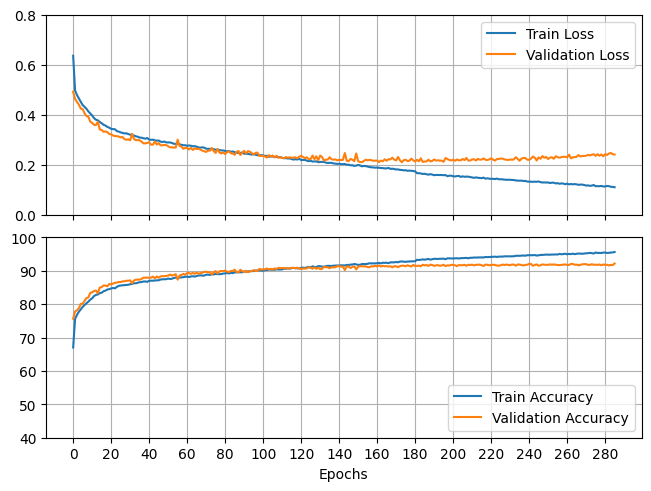

In [47]:
fig, axs = plt.subplots(2, 1,sharex=True)

axs[0].plot(range(len(tr_loss_lst)), tr_loss_lst, label='Train Loss')
axs[0].plot(range(len(val_loss_lst)), val_loss_lst, label='Validation Loss')
axs[0].set_ylim([0, 0.8])

axs[1].plot(range(len(tr_acc_lst)), tr_acc_lst, label='Train Accuracy')
axs[1].plot(range(len(val_acc_lst)), val_acc_lst, label='Validation Accuracy')
axs[1].set_ylim([40, 100])

axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')

axs[0].grid(True)
axs[1].grid(True)

axs[1].set_xlabel('Epochs')

axs[1].set_xticks(np.arange(0, len(val_acc_lst)+1, step=grid_step))

plt.show()

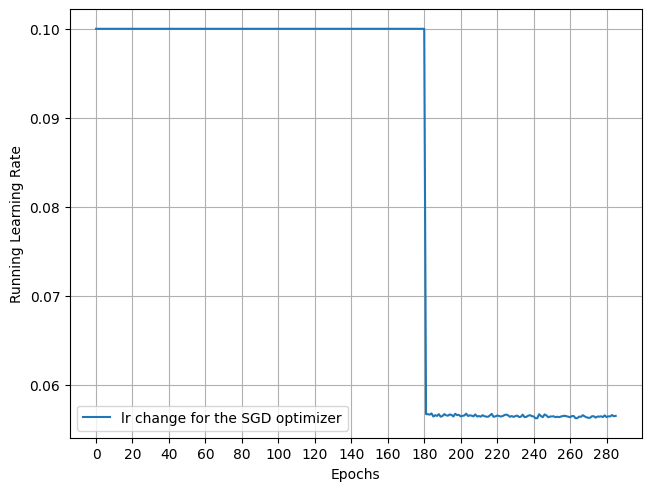

In [48]:
fig, axs = plt.subplots(1, 1)

axs.plot(range(len(running_lr_lst)), running_lr_lst,
         label=f'lr change for the {optimizer_lst[-1]} optimizer')
axs.set_xlabel('Epochs')
axs.set_ylabel('Running Learning Rate')
axs.set_xticks(np.arange(0, len(running_lr_lst)+1, step=grid_step))
axs.grid(True)
axs.legend()
plt.show()

In [49]:
if image_new_size != in_img_size:
    transform_test = transforms.Compose([
        v2.Resize(size=image_new_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])
else:
    transform_test = transforms.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])


test_set = Images_Dataset(df_test, transform_test)

test_loader = DataLoader(dataset=test_set,
                         batch_size=test_batch_size,
                         # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                         drop_last=True,
                         shuffle=False,
                         pin_memory=True,
                         num_workers=NUM_WORKERS)

In [50]:
x_test = []
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        x_test.extend(inputs.permute(0, 2, 3, 1).to('cpu').numpy())  # save inputs (ready for plot)
        y_pred.extend(predicted.data.to('cpu').numpy())  # Save Prediction
        y_true.extend(labels.data.to('cpu').numpy())  # Save Truth

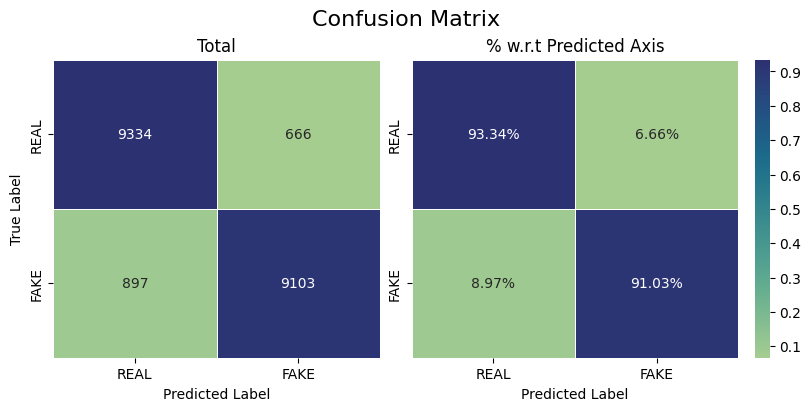

In [51]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
CM_df = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])

CM_recall = cf_matrix / np.sum(cf_matrix, axis=1)[:, None]
# Using [:,None] to slice a numpy row vector will turn it into column vector
CM_recall_df = pd.DataFrame(CM_recall, index=[i for i in classes], columns=[i for i in classes])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

g1 = sn.heatmap(CM_df, annot=True, fmt=".0f", linewidth=.5, cmap="crest", ax=axs[0], cbar=False)
g1.set(xlabel="Predicted Label", ylabel="True Label")
g1.set_title("Total")

g2 = sn.heatmap(CM_recall_df, annot=True, fmt=".2%", linewidth=.5, cmap="crest", ax=axs[1])
g2.set(xlabel="Predicted Label", ylabel="")
g2.set_title("% w.r.t Predicted Axis")
fig.suptitle("Confusion Matrix", fontsize=16)
plt.show()

In [52]:
print(f'Test Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%')
print(f'Test Recall: {recall_score(y_true, y_pred)*100:.2f}%')
print(f'Test f1 Score: {f1_score(y_true, y_pred)*100:.2f}%')

Test Accuracy: 92.18%
Test Recall: 91.03%
Test f1 Score: 92.09%


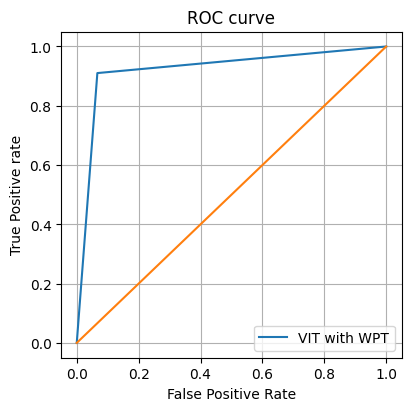

In [53]:
fpr,tpr,threshold=roc_curve(y_true,y_pred)
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='VIT with WPT')
plt.plot(p_fpr, p_tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [54]:
print(f'AUC Score {roc_auc_score(y_true,y_pred):0.2%}')

AUC Score 92.18%


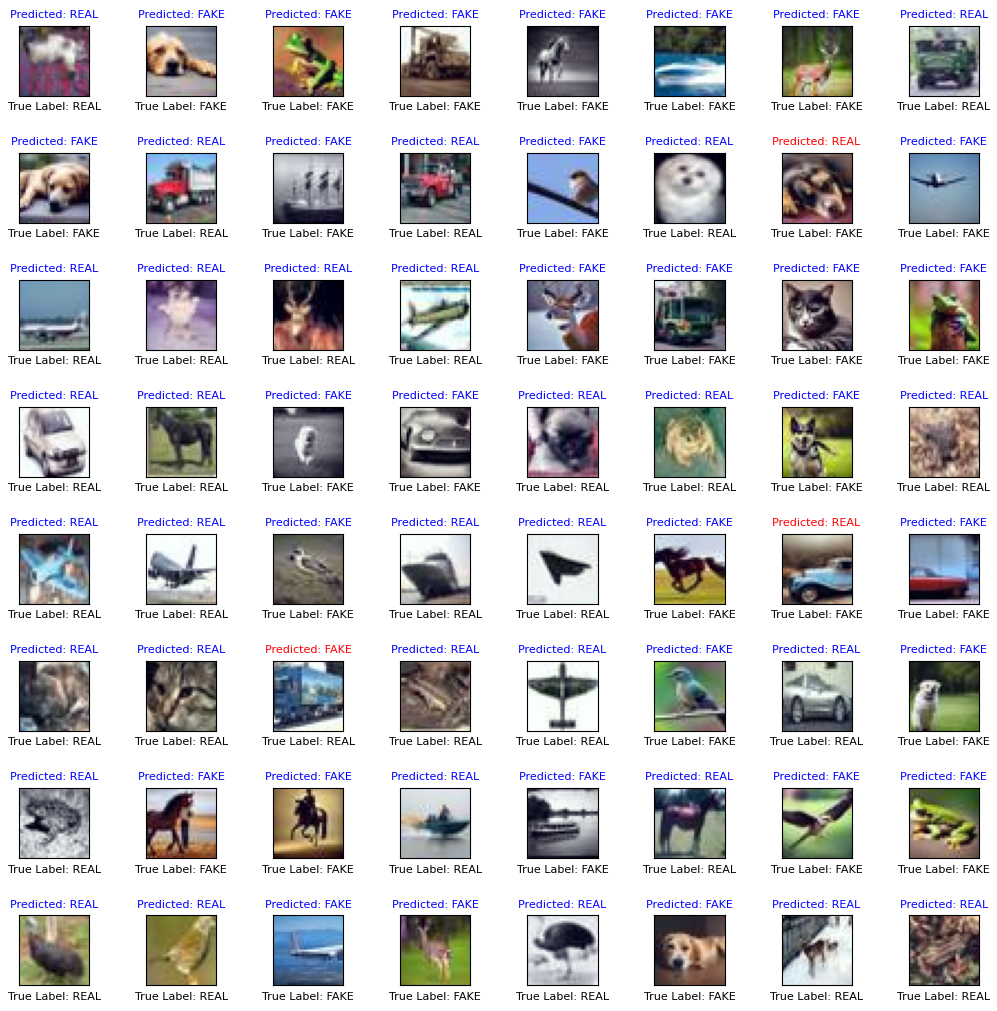

In [55]:
start_idx = 9980
sample_length = 64
cols = 8

test_idxs = range(start_idx, start_idx+sample_length)
rows = -(-sample_length//cols)
# print(rows)

figsize = (cols*1.25, rows*1.25)


margins = {  #inches
    "left":   1.0,
    "bottom": 1.0,
    "right":  1.1,
    "top":    1.1,
    "wspace": 0.2,
    "hspace": 0.2
}

fig, axs = plt.subplots(rows,cols, figsize=figsize, gridspec_kw=margins)

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = test_idxs[i*cols+j]

        tst_img = x_test[idx]
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        if pred_label == true_label:
            color = 'b'
        else:
            color = 'r'

        true_label_txt = f'True Label: {true_label}'
        pred_label_txt = f'Predicted: {pred_label}'

        ax.imshow(norm_to_plot(tst_img))
        ax.set_title(pred_label_txt, fontsize=8, color=color)
        ax.set_xlabel(true_label_txt, fontsize=8)
        ax.set(xticks=[], yticks=[])
plt.show()

In [56]:
sample_test_imgt_bch, sample_test_label_bch = next(iter(test_loader))

In [57]:
# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [58]:
h=model.transformer.layers[0][0].fn.softmax.register_forward_hook(getActivation('weights'))

test_output = model(sample_test_imgt_bch.to(device))

In [59]:
def plot_attention(attention_matrix, title, wpt_dim, step):
    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    hm = sn.heatmap(attention_matrix,
                    ax=ax,
                    cmap='Greens',
                    square=True,
                    cbar_kws={'shrink': 0.6})

    # Drawing the frame
    for _, spine in hm.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("k")

    fig.suptitle(f"Attention of a {title} Image", fontsize=16)

    all_patches = attention_matrix.shape[-1]

    ticks_line1 = np.arange(0, all_patches+1, step=1)
    ticks_line2 = np.arange(0, all_patches+1, step=step)

    ax.set_yticks(ticks_line1)
    ax.set_xticks(ticks_line1)

    ax.xaxis.set_minor_locator(ticker.FixedLocator(ticks_line1))
    ax.yaxis.set_minor_locator(ticker.FixedLocator(ticks_line1))
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_line2))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks_line2))

    ax.set_xticklabels(ticks_line2//patches_per_dec, rotation=0, fontsize=7)
    ax.set_yticklabels(ticks_line2//patches_per_dec, rotation=0, fontsize=7)

    ax.xaxis.set_ticks_position('top')
    ax.grid(True, which='major', color='k')
    ax.grid(True, which='minor', color='darkgray')
    # ax.minorticks_on()

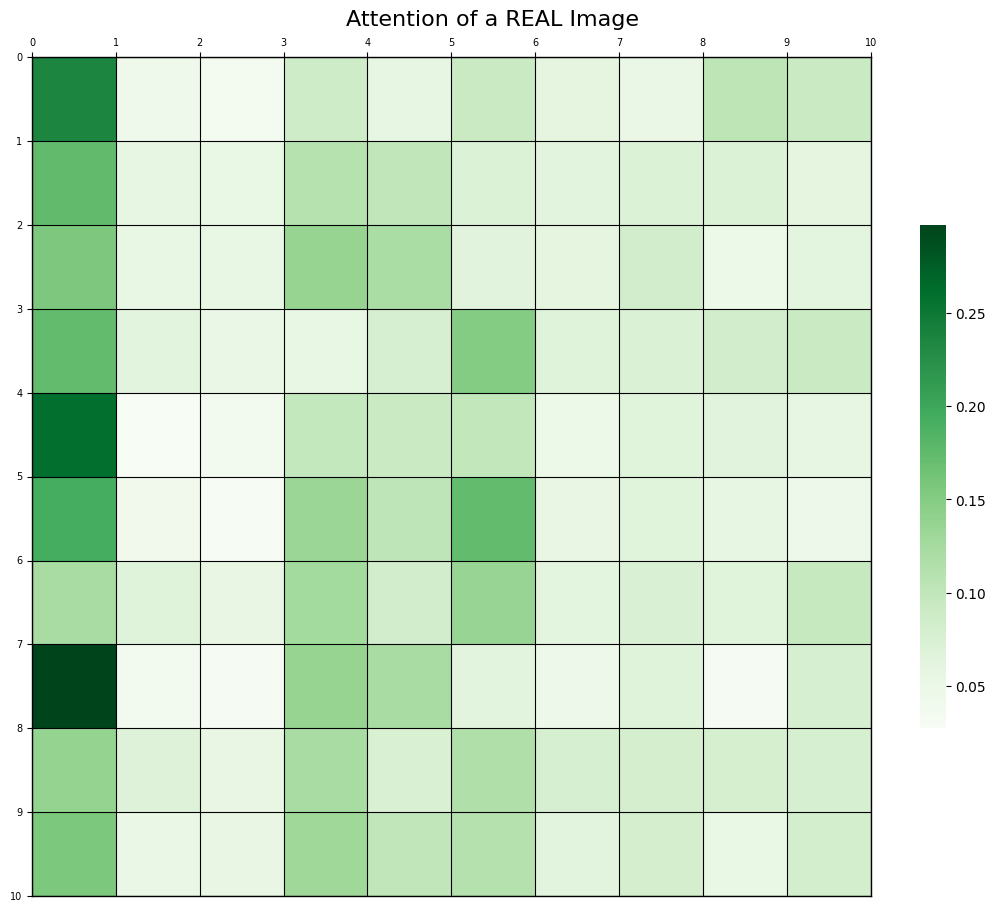

In [60]:
index = 0
mat1 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title1 = classes[sample_test_label_bch[index]]
plot_attention(mat1, title1, wpt_img_size, patches_per_dec)

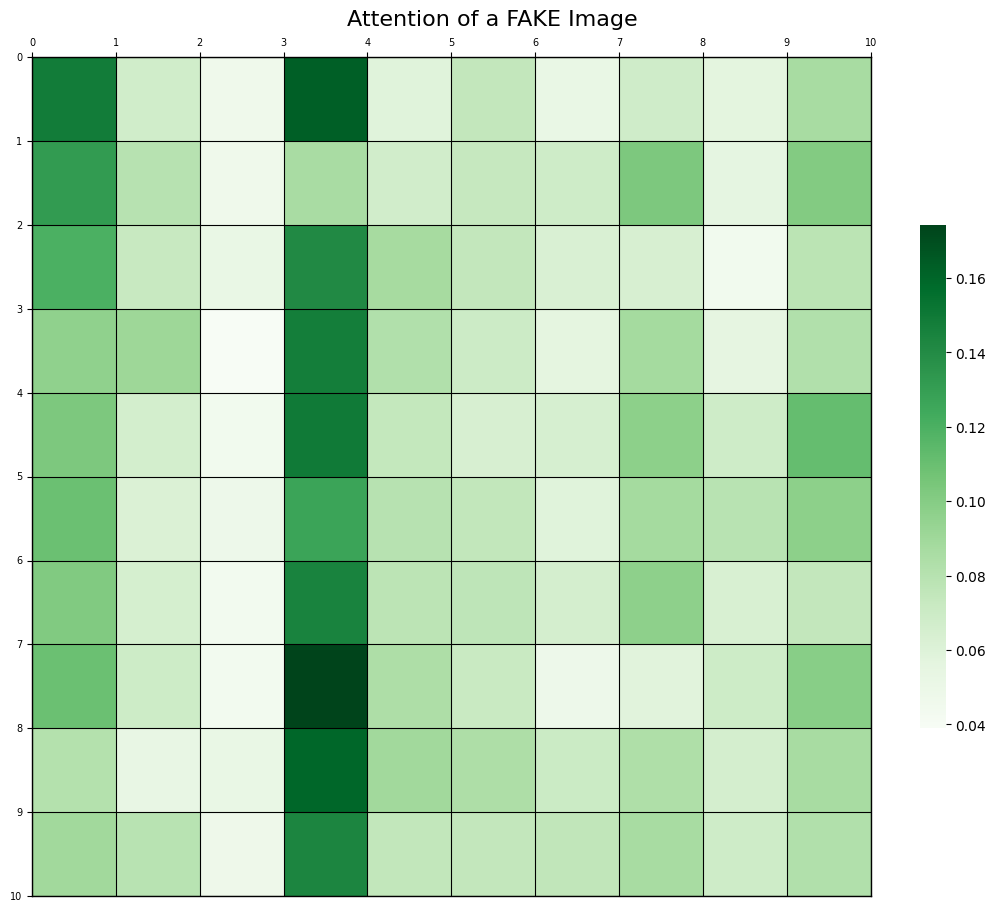

In [61]:
index = 900
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title2 = classes[sample_test_label_bch[index]]
plot_attention(mat2, title2, wpt_img_size,  patches_per_dec)

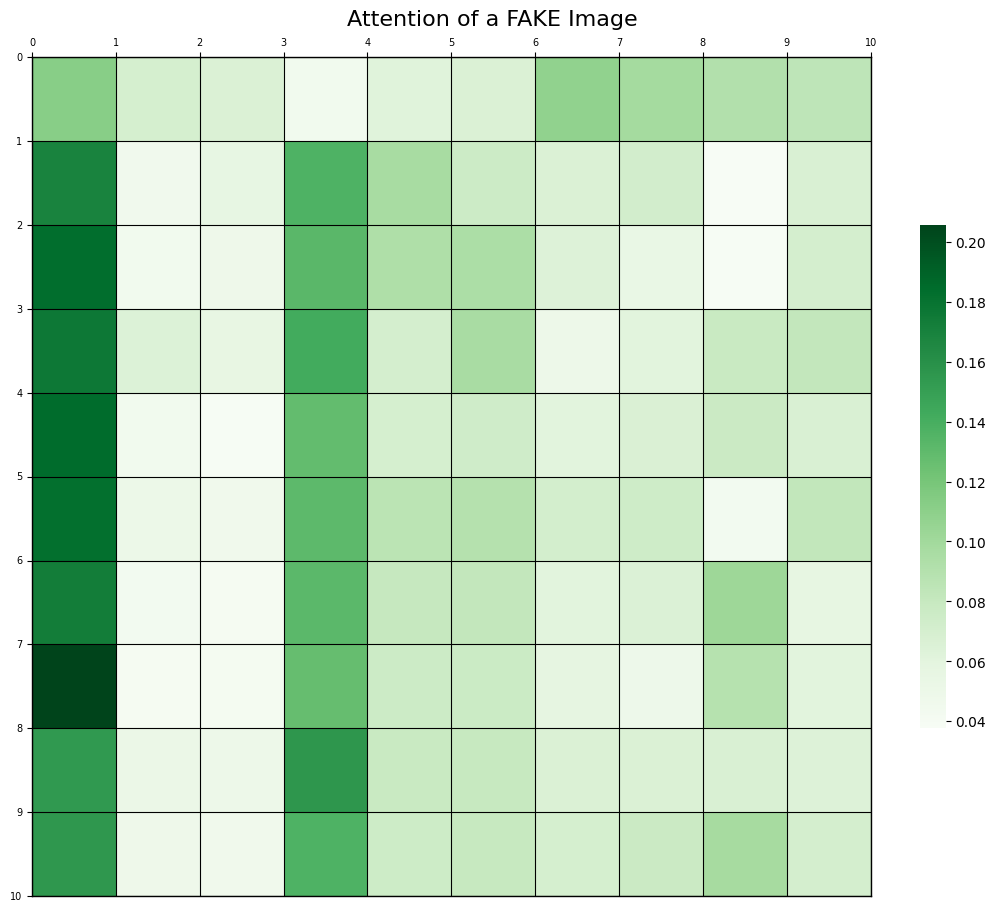

In [62]:
index = 660
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title2 = classes[sample_test_label_bch[index]]
plot_attention(mat2, title2, wpt_img_size,  patches_per_dec)

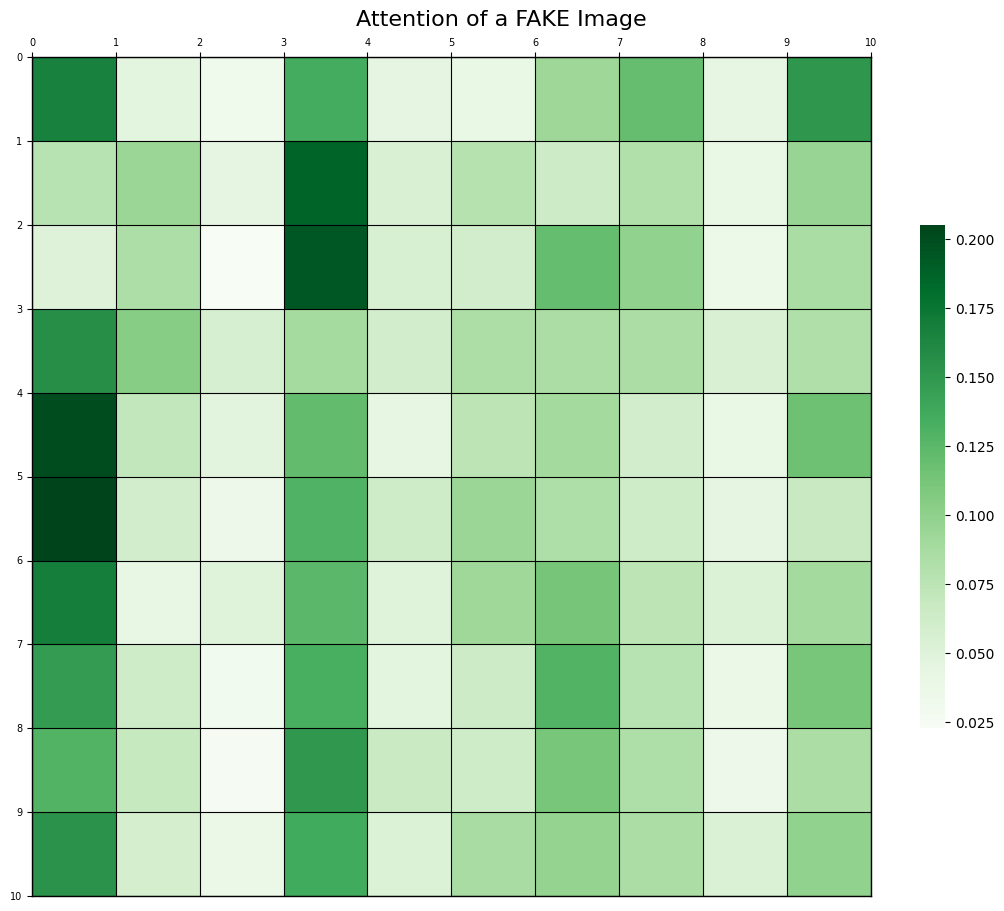

In [63]:
index = 20
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title2 = classes[sample_test_label_bch[index]]
plot_attention(mat2, title2, wpt_img_size,  patches_per_dec)

In [64]:
# I'm using 16 heads , while the original embedding size of flattened patches is 16 RGB pixels
# hence each head will compute the attention of a single RGB pixel
# every minor tick represent an image patch, and every major tick represents 
# one of the WPT decompositions of a sample test image. 
# By taking mean of the 16 heads attentions, we measure the attention between each patch and
# all of its spatial neighbors, at the same time we measure attention with patches from other 
# wavelet decompositions.
# Result shows that a high attention could be found between patches from different WPT decompositions.



: 